# Team TBD - Using AI to Predict Student Success

In [1]:
# Importing the necessary packages and libraries.
import pandas as pd
import io
import requests
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve,
    roc_auc_score, precision_recall_curve, recall_score, precision_score, f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

Specify file path and create target variable

In [2]:
# Load the data
file_id = '17eoOjbTriXdOnuUC2LSHDe-9lA-V_h1X'   # File ID from Google Drive points to the dataset
url = f'https://drive.google.com/uc?id={file_id}'

# Send GET request to download the file
response = requests.get(url)

# Use io.BytesIO to read the content into pandas directly
df = pd.read_csv(io.BytesIO(response.content))

# Create target variable column, "Graduated" based on Graduation_Rate
df['Graduated'] = (df['Graduation_Rate'] >= 0.6).astype(int)

In [3]:
# Display the first 10 rows of the dataset
df.head(10)

,Student_ID,GPA,SAT_Score,ACT_Score,Family_Size,Income_Level,Marital_Status,Support_Center_Utilization,Retention_Rate,Graduation_Rate,...,Graduation_Age,Major,Study_Hours_Per_Week,Student_Loan_Amount,Campus_Engagement,First_Gen_Student,Enrollment_Status,Distance_From_Home,Work_Hours_Per_Week,Graduated
0,1,2.73,1174,26,1,High,Married,0.23,0.72,0.62,...,22.3,STEM,13.3,30968.51,Low,False,Full-Time,42.0,16.9,1
1,2,2.61,1079,24,4,High,Married,0.15,0.68,0.63,...,23.0,STEM,25.1,18679.95,Low,True,Full-Time,5.0,4.4,1
2,3,2.81,1197,26,4,Low,Married,0.47,0.61,0.58,...,22.4,Education,15.1,39004.41,Low,False,Full-Time,62.9,9.5,0
3,4,3.35,1328,29,1,High,Divorced,0.00,0.90,0.90,...,22.5,STEM,13.1,15563.23,Low,False,Full-Time,93.1,4.2,1
4,5,3.02,1064,23,1,Middle,Single,0.22,0.61,0.66,...,22.9,Arts,21.8,6533.81,Low,False,Full-Time,63.1,15.5,1
5,6,2.43,1064,23,1,Middle,Divorced,0.26,0.54,0.58,...,22.5,STEM,13.0,28718.06,Medium,False,Full-Time,64.8,14.7,0
6,7,3.64,1336,30,4,Low,Single,0.28,0.71,0.65,...,22.0,Arts,17.1,21571.52,Low,False,Full-Time,65.2,8.7,1
7,8,2.80,1215,27,1,Low,Single,0.36,0.86,0.84,...,23.0,Health Sciences,15.3,8249.42,High,False,Full-Time,95.8,8.9,1
8,9,2.32,1029,23,1,Middle,Single,0.56,0.56,0.56,...,23.1,Arts,15.7,19196.86,Low,False,Part-Time,65.8,8.3,0
9,10,3.20,1181,26,1,Middle,Married,0.37,1.00,0.99,...,22.0,Business,3.1,16445.08,Medium,False,Full-Time,90.8,14.4,1


Creating lists of columns to make it easier for encoding and scaling later

In [4]:
# Setup columns that need to be scaled or encoded
numerical_columns = ["GPA", "SAT_Score", "ACT_Score", "Family_Size", "Support_Center_Utilization",
                     "Retention_Rate", "Graduation_Age", "Study_Hours_Per_Week", "Student_Loan_Amount", "Distance_From_Home", "Work_Hours_Per_Week"]
nominal_columns = ["Marital_Status", "Life_Event", "Major"]
ordinal_columns = ["Income_Level", "Institution_Type", "Campus_Engagement", "First_Gen_Student", "Enrollment_Status"]

Checking for imbalanced data (displaying the split between "Graduated" 1 and 0)

In [5]:
df['Graduated'].value_counts()

Graduated
1    7159
0    2841
Name: count, dtype: int64

Display information about the dataset

In [6]:
# Check for missing values
print(df.isnull().sum())

Student_ID                       0
GPA                              0
SAT_Score                        0
ACT_Score                        0
Family_Size                      0
Income_Level                     0
Marital_Status                   0
Support_Center_Utilization       0
Retention_Rate                   0
Graduation_Rate                  0
Life_Event                    6022
Institution_Type                 0
Graduation_Age                   0
Major                            0
Study_Hours_Per_Week             0
Student_Loan_Amount              0
Campus_Engagement                0
First_Gen_Student                0
Enrollment_Status                0
Distance_From_Home               0
Work_Hours_Per_Week              0
Graduated                        0
dtype: int64


In [7]:
# Replacing empty values in Life_event to 'None'
df['Life_Event'] = df['Life_Event'].fillna('None')

In [8]:
# Prepare data
X = df.drop(columns=["Student_ID", "Graduation_Rate", "Graduated"])
y = df["Graduated"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

Number of training samples: 6700
Number of testing samples: 3300


We can encode and scale the data but we will keep that data in a separate dataframe so we can also automate this process in a pipeline
</br>
We use this mainly for data visualization and checking correlation

In [9]:
# Scale numerical columns
scaler = StandardScaler()
X_train_encoded_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_encoded_scaled = scaler.transform(X_test[numerical_columns])

# One-hot encode categorical (nominal) variables
X_train_encoded_scaled = pd.get_dummies(X_train, columns=nominal_columns, drop_first=True)

# Apply the same encoding to the test set
X_test_encoded_scaled = pd.get_dummies(X_test, columns=nominal_columns, drop_first=True)

# Handle categorical (ordinal) columns
le = LabelEncoder()
for col in ordinal_columns:
    X_train_encoded_scaled[col] = le.fit_transform(X_train_encoded_scaled[col])
    X_test_encoded_scaled[col] = le.transform(X_test_encoded_scaled[col])

In [10]:
# Convert only boolean columns (True/False) to 1/0
boolean_columns = X_train_encoded_scaled.select_dtypes(include=['bool']).columns
X_train_encoded_scaled[boolean_columns] = X_train_encoded_scaled[boolean_columns].astype(int)
X_test_encoded_scaled[boolean_columns] = X_test_encoded_scaled[boolean_columns].astype(int)

In [11]:
X_test_encoded_scaled.head()

,GPA,SAT_Score,ACT_Score,Family_Size,Income_Level,Support_Center_Utilization,Retention_Rate,Institution_Type,Graduation_Age,Study_Hours_Per_Week,...,Work_Hours_Per_Week,Marital_Status_Married,Marital_Status_Single,Life_Event_Financial Problems,Life_Event_Health Issues,Life_Event_None,Major_Business,Major_Education,Major_Health Sciences,Major_STEM
6252,3.81,1495,33,2,0,0.00,1.00,0,22.8,15.1,...,7.1,0,1,0,0,1,0,0,0,0
4684,2.14,944,21,1,2,0.30,0.64,1,23.2,16.5,...,2.5,0,0,0,0,1,0,0,1,0
1731,3.35,1047,23,1,0,0.12,1.00,0,23.1,14.4,...,5.4,0,1,0,0,1,0,0,0,0
4742,2.90,1100,24,4,0,0.32,0.70,1,23.1,18.8,...,13.8,0,1,0,0,1,0,0,0,1
4521,3.20,1261,28,3,2,0.47,0.63,0,22.0,1.1,...,9.4,1,0,0,0,1,0,0,1,0


# Utilizing Pipelines

GridSearch for K-Nearest Neighbors

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numeric columns
        ('cat', OneHotEncoder(), nominal_columns),  # One-hot encode categorical columns
        ('ord', OrdinalEncoder(), ordinal_columns)  # Ordinal encode ordinal columns
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors=5))
])

# Define parameter grid for KNN
param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['euclidean', 'manhattan']
}

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_knn_model = grid_search.best_estimator_

# Make predictions on training data
train_predictions = best_knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Make predictions on testing data
test_predictions = best_knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
report = classification_report(y_test, test_predictions)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}\n")
print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}\n")
print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}\n")
print(f"Training F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix, "\n")
print("Classification Report:\n", report)

Best Parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 11, 'model__weights': 'uniform'}
Training Accuracy: 0.8851
Testing Accuracy: 0.8518

Training Recall: 0.9437
Test Recall: 0.9225

Training Precision: 0.9010
Test Precision: 0.8758

Training F1: 0.9218
Test F1: 0.8985

Confusion Matrix:
 [[ 646  307]
 [ 182 2165]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73       953
           1       0.88      0.92      0.90      2347

    accuracy                           0.85      3300
   macro avg       0.83      0.80      0.81      3300
weighted avg       0.85      0.85      0.85      3300



GridSearch for Logistic Regression

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numeric columns
        ('cat', OneHotEncoder(), nominal_columns),  # One-hot encode categorical columns
        ('ord', OrdinalEncoder(), ordinal_columns)  # Ordinal encode ordinal columns
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

# Define parameter grid for Logistic Regression
param_grid = {
    'model__C': [0.1, 1.0, 10.0],
    'model__solver': ['liblinear', 'saga'],
    'model__penalty': ['l1', 'l2']
}

# Grid search with pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_logistic_regression_model = grid_search.best_estimator_

# Make predictions on training data
train_predictions = best_logistic_regression_model.predict(X_train)
train_accuracy = accuracy_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)
train_precision = precision_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)

# Make predictions on testing data
test_predictions = best_logistic_regression_model.predict(X_test)
y_test_proba = best_logistic_regression_model.predict_proba(X_test)[:, 1]
test_accuracy = accuracy_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)
test_precision = precision_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
conf_matrix = confusion_matrix(y_test, test_predictions)
report = classification_report(y_test, test_predictions)

# Print the results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}\n")
print(f"Training Recall: {train_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}\n")
print(f"Training Precision: {train_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}\n")
print(f"Training F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}\n")
print("Confusion Matrix:\n", conf_matrix, "\n")
print("Classification Report:\n", report, "\n")
print(f"Predicted Class Distribution: {np.bincount(test_predictions)}")


Best Parameters: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'saga'}
Training Accuracy: 0.9104
Testing Accuracy: 0.9064

Training Recall: 0.9441
Test Recall: 0.9399

Training Precision: 0.9321
Test Precision: 0.9292

Training F1: 0.9381
Test F1: 0.9345

Confusion Matrix:
 [[ 785  168]
 [ 141 2206]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.84       953
           1       0.93      0.94      0.93      2347

    accuracy                           0.91      3300
   macro avg       0.89      0.88      0.89      3300
weighted avg       0.91      0.91      0.91      3300
 

Predicted Class Distribution: [ 926 2374]


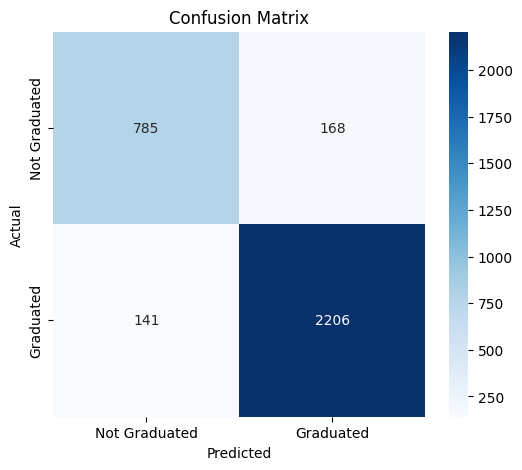

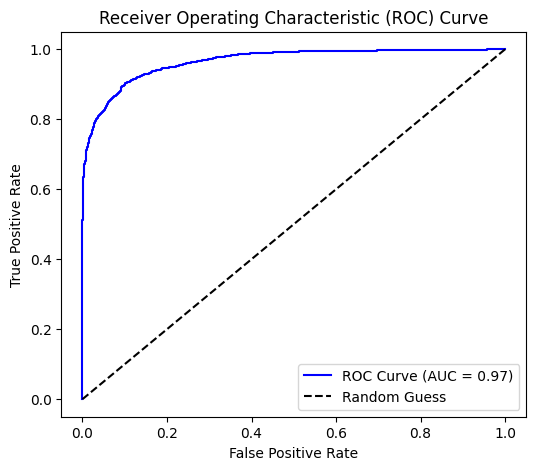

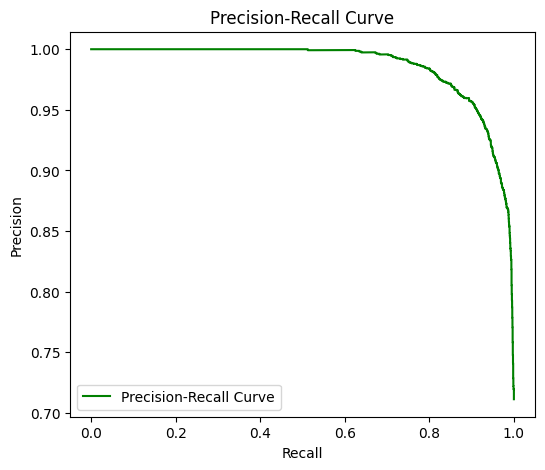

In [14]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Precision-Recall Curve (with zero_division parameter)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

# Code that iterates through different models

In [15]:
# Create the preprocessor (without scaling for models that don't need it)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), nominal_columns),      # One-hot encode categorical columns
        ('ord', OrdinalEncoder(), ordinal_columns)    # Ordinal encode ordinal columns
    ]
)

# List of models to iterate over
models = [
    ('Support Vector Machine', SVC()),
    ('Random Forest', RandomForestClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB())
]

# Iterate through models and compare train and test accuracy
for model_name, model in models:
    # If the model requires scaling, add StandardScaler
    if isinstance(model, SVC):  # these models requires scaling
        preprocessor_with_scaling = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numerical_columns),  # Scale numeric columns
                ('cat', OneHotEncoder(), nominal_columns),      # One-hot encode categorical columns
                ('ord', OrdinalEncoder(), ordinal_columns)    # Ordinal encode ordinal columns
            ]
        )
    else:
        preprocessor_with_scaling = preprocessor  # Use the preprocessor without scaling for other models

    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor_with_scaling),  # Preprocessing steps
        ('model', model)  # Model
    ])

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the training and test data
    train_predictions = pipeline.predict(X_train)
    test_predictions = pipeline.predict(X_test)

    # Calculate accuracy on the training set
    train_accuracy = accuracy_score(y_train, train_predictions)
    train_recall = recall_score(y_train, train_predictions)
    train_precision = precision_score(y_train, train_predictions)
    train_f1 = f1_score(y_train, train_predictions)

    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_recall = recall_score(y_test, test_predictions)
    test_precision = precision_score(y_test, test_predictions)
    test_f1 = f1_score(y_test, test_predictions)

    # Print the model and its accuracy results
    print(f"{model_name}:")
    print(f"  Training Accuracy: {train_accuracy:.4f}")
    print(f"  Test Accuracy: {test_accuracy:.4f}\n")
    print(f"  Training Recall: {train_recall:.4f}")
    print(f"  Test Recall: {test_recall:.4f}\n")
    print(f"  Training Precision: {train_precision:.4f}")
    print(f"  Test Precision: {test_precision:.4f}\n")
    print(f"  Training F1: {train_f1:.4f}")
    print(f"  Test F1: {test_f1:.4f}\n")

Support Vector Machine:
  Training Accuracy: 0.9282
  Test Accuracy: 0.8988

  Training Recall: 0.9551
  Test Recall: 0.9395

  Training Precision: 0.9455
  Test Precision: 0.9199

  Training F1: 0.9503
  Test F1: 0.9296

Random Forest:
  Training Accuracy: 0.7760
  Test Accuracy: 0.6652

  Training Recall: 0.9487
  Test Recall: 0.8875

  Training Precision: 0.7845
  Test Precision: 0.7124

  Training F1: 0.8588
  Test F1: 0.7904

Decision Tree:
  Training Accuracy: 0.7760
  Test Accuracy: 0.6330

  Training Recall: 0.9181
  Test Recall: 0.8219

  Training Precision: 0.7996
  Test Precision: 0.7087

  Training F1: 0.8548
  Test F1: 0.7611

Naive Bayes:
  Training Accuracy: 0.7182
  Test Accuracy: 0.7112

  Training Recall: 1.0000
  Test Recall: 1.0000

  Training Precision: 0.7182
  Test Precision: 0.7112

  Training F1: 0.8360
  Test F1: 0.8312



# Looking at Feature Importance

We need to use both chi2 and mutual information because our dataset has both numeric and categorical data

In [16]:
# Encode categorical features if needed
# Chi2 requires categorical features to be in numeric form (e.g., one-hot encoding or label encoding)
categorical_features = X.select_dtypes(include=['object', 'category'])
categorical_features_encoded = pd.get_dummies(categorical_features)

# Scale numeric features
numeric_features = X.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
numeric_features_scaled = scaler.fit_transform(numeric_features)

# Perform Chi-squared test on categorical features
chi2_scores, chi2_p = chi2(categorical_features_encoded, y)

# Perform Mutual Information test on numeric features
mi_scores = mutual_info_classif(numeric_features_scaled, y, random_state=42)

# Combine and display results
# Chi2 results
chi2_results = pd.DataFrame({
    'Feature': categorical_features_encoded.columns,
    'Chi2_Score': chi2_scores,
    'P_Value': chi2_p
}).sort_values(by='Chi2_Score', ascending=False)

# Mutual Information results
mi_results = pd.DataFrame({
    'Feature': numeric_features.columns,
    'Mutual_Info_Score': mi_scores
}).sort_values(by='Mutual_Info_Score', ascending=False)

print("Chi-Squared Test Results (Categorical Features):")
print(chi2_results)

print("\nMutual Information Test Results (Numeric Features):")
print(mi_results)

Chi-Squared Test Results (Categorical Features):
                          Feature  Chi2_Score   P_Value
17         Campus_Engagement_High    4.728557  0.029666
8        Life_Event_Health Issues    4.470572  0.034483
7   Life_Event_Financial Problems    3.523489  0.060505
3         Marital_Status_Divorced    1.874719  0.170936
19       Campus_Engagement_Medium    1.374560  0.241030
15          Major_Health Sciences    1.031818  0.309732
9                 Life_Event_None    0.935531  0.333430
21    Enrollment_Status_Part-Time    0.857007  0.354578
6        Life_Event_Family Issues    0.344368  0.557319
10       Institution_Type_Private    0.337153  0.561477
12                     Major_Arts    0.305332  0.580559
1                Income_Level_Low    0.294148  0.587574
20    Enrollment_Status_Full-Time    0.216399  0.641798
4          Marital_Status_Married    0.165300  0.684323
18          Campus_Engagement_Low    0.157189  0.691758
11        Institution_Type_Public    0.146220  0.702174

Permutation Importance
</br>
This is where we use the encoded and scaled data

In [17]:
# Assume X_train, X_test, y_train, y_test are already defined
# Initialize and fit the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_encoded_scaled, y_train)

# Perform permutation importance
result = permutation_importance(model, X_test_encoded_scaled, y_test, n_repeats=10, random_state=42)

# Get feature importances
importance_df = pd.DataFrame({
    'Feature': X_test_encoded_scaled.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                          Feature    Importance
6                  Retention_Rate  3.014242e-01
0                             GPA  4.636364e-03
2                       ACT_Score  2.636364e-03
14             Distance_From_Home  2.424242e-03
9            Study_Hours_Per_Week  2.060606e-03
1                       SAT_Score  1.424242e-03
13              Enrollment_Status  1.272727e-03
20                Life_Event_None  1.121212e-03
8                  Graduation_Age  1.121212e-03
24                     Major_STEM  1.060606e-03
12              First_Gen_Student  9.090909e-04
5      Support_Center_Utilization  8.787879e-04
16         Marital_Status_Married  8.181818e-04
3                     Family_Size  4.545455e-04
21                 Major_Business  3.636364e-04
22                Major_Education  3.333333e-04
7                Institution_Type  3.030303e-04
17          Marital_Status_Single  2.727273e-04
23          Major_Health Sciences  9.090909e-05
18  Life_Event_Financial Problems  3.030

# Using K-Means Clustering
We will do this to categorize/cluster similar points

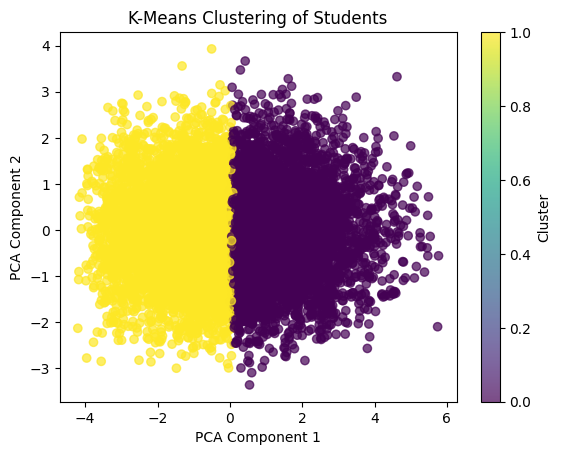

In [18]:
# Select relevant features for clustering
features = ['GPA', 'SAT_Score', 'ACT_Score', 'Income_Level', 'Support_Center_Utilization', 'Life_Event', 'Institution_Type',
            'Study_Hours_Per_Week', 'Campus_Engagement', 'First_Gen_Student', 'Enrollment_Status', 'Distance_From_Home', 'Work_Hours_Per_Week']  # Update with actual feature names
X = df[features]

# Preprocess data
# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

# Preprocessing for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('kmeans', KMeans(n_clusters=2, random_state=42))
])

# Fit the pipeline
pipeline.fit(X)

# Add the cluster labels to the original dataframe
df['cluster'] = pipeline['kmeans'].labels_

# Optional: Reduce dimensionality for easier clustering visualization
X_transformed = pipeline['preprocessor'].transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transformed)

# Visualize the clusters
import matplotlib.pyplot as plt

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title('K-Means Clustering of Students')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


# Running models without using a Pipeline

LOGISTIC REGRESSION

In [19]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled = scaler.transform(X_test[numerical_columns])

# Train logistic regression model
model = LogisticRegression(max_iter=2000, solver='saga')
model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

In [20]:
# Evaluate model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

# Print results
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

Training Accuracy: 0.9095522388059701
Test Accuracy: 0.9081818181818182
Confusion Matrix:
 [[ 791  162]
 [ 141 2206]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84       953
           1       0.93      0.94      0.94      2347

    accuracy                           0.91      3300
   macro avg       0.89      0.88      0.89      3300
weighted avg       0.91      0.91      0.91      3300



In [21]:
print(f"Predicted Class Distribution: {np.bincount(y_test_pred)}")

Predicted Class Distribution: [ 932 2368]


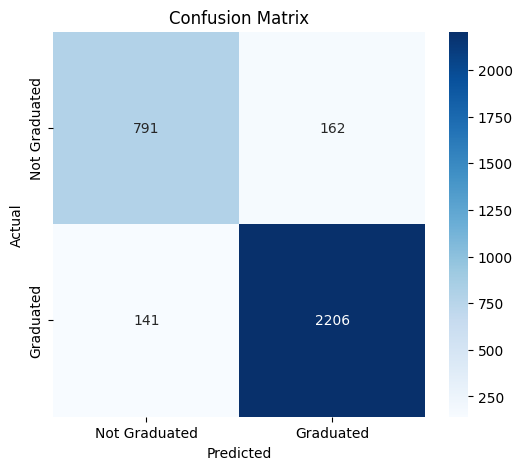

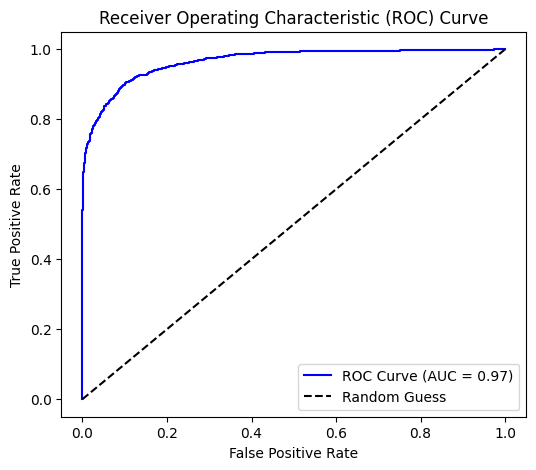

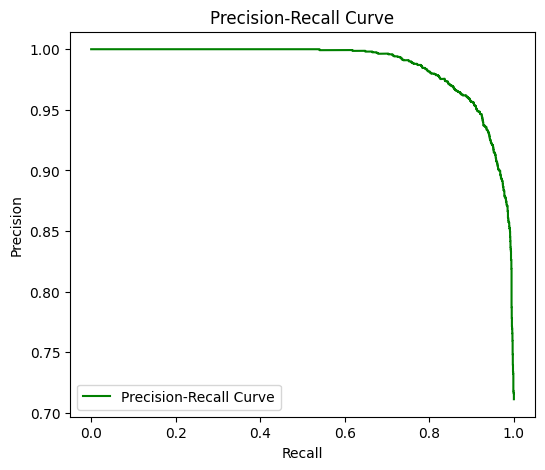

In [22]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Precision-Recall Curve (with zero_division parameter)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

DECISION FOREST


In [ ]:
model = DecisionTreeClassifier(random_state=42,max_depth=4)
# When using Decision Trees, we do not want to scale the data.
# model.fit(X_train_scaled, y_train)
model.fit(X_train, y_train)

In [ ]:
from sklearn.tree import plot_tree

# Plot the trained decision tree
plt.figure(figsize=(40, 30))
plot_tree(model, filled=True, feature_names=X.columns, class_names=["Not Graduated", "Graduated"], rounded=True, fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

In [ ]:
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

# Evaluate model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)
print(f"Predicted Class Distribution: {np.bincount(y_test_pred)}")


In [ ]:
# Visualization 1: Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Visualization 3: Precision-Recall Curve (with zero_division parameter)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve", color='green')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

RANDOM FOREST

In [ ]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
# rf_model.fit(X_train_scaled, y_train)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Graduated", "Graduated"], yticklabels=["Not Graduated", "Graduated"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset (assuming df is your DataFrame and you've already preprocessed it)
# Assuming your target is 'Graduation_Rate' (converted to 0 or 1 for classification)

'''
# Prepare features and target
X = df.drop(columns=['Student_ID', 'Graduation_Rate'])  # Dropping ID and target column
y = df['Graduation_Rate'].apply(lambda x: 1 if x >= 0.5 else 0)  # Binary target (0 or 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
'''

# Initialize the base model (Decision Tree as the weak learner for AdaBoost)
base_model = DecisionTreeClassifier(max_depth=1)

# Initialize AdaBoost with the base model
ada_boost = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=42)

# Fit the AdaBoost model
ada_boost.fit(X_train, y_train)

# Predict on test data
y_pred = ada_boost.predict(X_test)
y_pred_proba = ada_boost.predict_proba(X_test)[:, 1]

# Model Evaluation

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

# Classification Report
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot ROC curve using Plotly
fig_roc = go.Figure()

fig_roc.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'ROC Curve (AUC = {roc_auc:.2f})',
    line=dict(color='#FF6347', width=3)  # Tomato red color
))

fig_roc.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name="Random Guess",
    line=dict(color='#D3D3D3', dash='dash', width=2)  # Light gray for random guess
))

fig_roc.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig_roc.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

# Plot Precision-Recall curve using Plotly
fig_prc = go.Figure()

fig_prc.add_trace(go.Scatter(
    x=recall,
    y=precision,
    mode='lines',
    name="Precision-Recall Curve",
    line=dict(color='#32CD32', width=3)  # Lime green color
))

fig_prc.update_layout(
    title="Precision-Recall Curve",
    xaxis_title="Recall",
    yaxis_title="Precision",
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    paper_bgcolor='rgba(0,0,0,0)',  # Transparent background
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False)
)

fig_prc.show()

# Confusion Matrix Heatmap
fig_cm = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=["Not Graduated", "Graduated"],
    y=["Not Graduated", "Graduated"],
    colorscale='RdBu',  # Red-Blue color scale for better contrast
    showscale=True
)

fig_cm.update_layout(
    title="Confusion Matrix",
    xaxis_title="Predicted",
    yaxis_title="Actual",
    xaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Not Graduated", "Graduated"]),
    yaxis=dict(tickmode='array', tickvals=[0, 1], ticktext=["Not Graduated", "Graduated"]),
)

fig_cm.show()
